In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics

df = pd.read_csv('clustering_data.csv',sep='\t')
df.head()

,temp,turbo,fuel_type,fuel_rate
0,203.652692,No,biofuel,19.0
1,198.722232,No,petrol,19.0
2,180.636798,Yes,diesel,16.0
3,192.932929,No,petrol,22.0
4,197.970688,No,petrol,17.0


SK Learn can handle numbers only for clustering
Simple case with numerical data

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


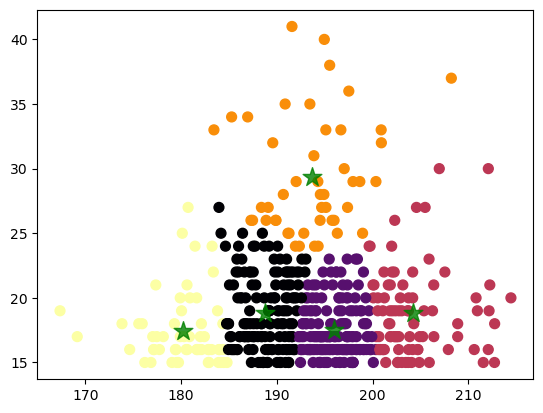

436.23206885716843
8466.588563069818


In [3]:
data = df.loc[:,['temp','fuel_rate']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)
# Remember that kmeans is unsupervised
y_kmeans = kmeans.predict(data)
# predict() determines which cluster each input data point belongs to, 
# based on distance to the learned centroids

# print(y_kmeans)

plt.scatter(data.loc[:,'temp'],data.loc[:,'fuel_rate'],c=y_kmeans, s=50,cmap='inferno')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.8, marker='*')
plt.show()
print(metrics.calinski_harabasz_score(data,kmeans.labels_))
print(kmeans.inertia_)



Let us see how the clustering would work if we did not have data scattered in the middle of the distribution you saw above
We remove a percentage of the rows; first we should create an array of indices corresponding to the condition and then drop those rows

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


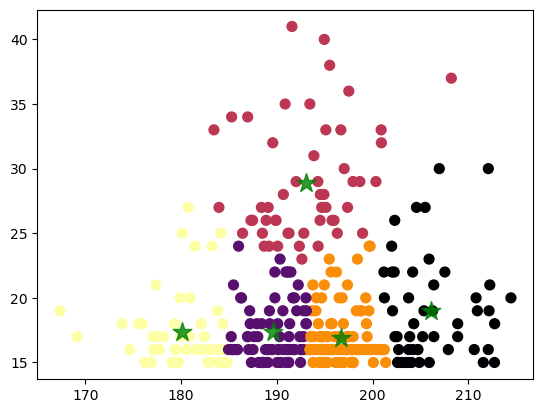

In [5]:
mask = data['temp'].between(180, 205) & data['fuel_rate'].between(17, 24)
rows_to_remove = int(np.ceil(mask.sum() * 0.6)) # removing 60%
rows_to_drop = data[mask].sample(n=rows_to_remove, random_state=1).index

data_lean = data.drop(rows_to_drop)

# data_lean = d.loc[:,['temp','fuel_rate']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_lean)
y_kmeans = kmeans.predict(data_lean)
# print(y_kmeans)

plt.scatter(data_lean.loc[:,'temp'],data_lean.loc[:,'fuel_rate'],c=y_kmeans, s=50,cmap='inferno')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.8, marker='*')
plt.show()


In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# a popular approach these days is to use a pipeline
# from sklearn.pipeline import make_pipeline
# Define column transformer

df['turbo'] = df['turbo'].replace({'Yes': 1, 'No':0}) # or alternatively with Function Transformer 
# but won't be able to use the function get_feature_names_out with binary transformation
# Define a simple function to convert Yes/No to 1/0
# def yes_no_to_numeric(x):
#     return np.where(x == 'Yes', 1, 0)

column_transformer = ColumnTransformer(
    transformers=[
        # ('binary', FunctionTransformer(yes_no_to_numeric), ['turbo']),
        ('num', StandardScaler(), ['temp', 'fuel_rate']),
        ('cat', OneHotEncoder(), ['fuel_type'])
    ]
    , remainder='passthrough'  # Include the binary variable without transformation
)
transformed_data = column_transformer.fit_transform(df)
# print(transformed_data)



# Get the output feature names
feature_names = column_transformer.get_feature_names_out()


# Create a DataFrame with the transformed data and the new column names
transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
# rename feature names
mapping_name = {feature_names[0]: 'temp',
                feature_names[1]: 'fuel_rate',
                feature_names[2]: 'biofuel',
                feature_names[3]: 'diesel',
                feature_names[4]: 'petrol',
                feature_names[5]: 'turbo',
}
transformed_df.rename(columns=mapping_name, inplace=True)
# print(feature_names)
# transformed_df['num__fuel_rate']

The use of a Pipeline in scikit-learn offers some advantages, particularly in streamlining the process of applying a sequence of data transformations and model training. Here are some key benefits:

Simplicity and Clarity: A pipeline bundles together preprocessing and modeling steps, making the code more organized, readable, and concise. It allows for a clear representation of the sequence of operations applied to the data.

Avoiding Data Leakage: When preprocessing data (like scaling or normalizing), it's crucial to fit the preprocessing steps only on the training data and not on the full dataset to avoid data leakage. Pipelines automatically handle this by ensuring that the same transformation fitted on the training data is applied to the test data, maintaining the integrity of the validation process.

Ease of Modification and Validation: Changing preprocessing steps or swapping out models becomes straightforward with a pipeline. This encapsulation makes experimenting with different models or preprocessing techniques more manageable and less error-prone.

Efficiency: Pipelines can streamline the process of cross-validation and grid searches by ensuring that preprocessing steps are only fitted once per training fold, reducing computational overhead.

Deployment: A pipeline encapsulates the entire process from raw data to predictions, which simplifies deployment. A trained pipeline model can be saved and then used directly to make predictions on new data with the preprocessing steps automatically applied.

In [7]:
# block commente with """ """
"""
# if using pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# a popular approach these days is to use a pipeline
# from sklearn.pipeline import make_pipeline
# Define column transformer

# Define a simple function to convert Yes/No to 1/0
# def yes_no_to_numeric(x):
#     return np.where(x == 'Yes', 1, 0)

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', FunctionTransformer(yes_no_to_numeric), ['turbo']),
        ('num', StandardScaler(), ['temp', 'fuel_rate']),
        ('cat', OneHotEncoder(), ['fuel_type'])
    ]
    # , remainder='passthrough'  # applies if we have remaining variables w/t transformation
)
transformed_data = column_transformer.fit_transform(df)

# Create K-means clustering pipeline
pipeline = make_pipeline(preprocessor, KMeans(n_clusters=4))

# Fit the model
pipeline.fit(data)

# Predict cluster labels
clusters = pipeline.predict(data)
"""

"\n# if using pipeline\n\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer\nfrom sklearn.compose import ColumnTransformer\n\n# a popular approach these days is to use a pipeline\n# from sklearn.pipeline import make_pipeline\n# Define column transformer\n\n# Define a simple function to convert Yes/No to 1/0\n# def yes_no_to_numeric(x):\n#     return np.where(x == 'Yes', 1, 0)\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('binary', FunctionTransformer(yes_no_to_numeric), ['turbo']),\n        ('num', StandardScaler(), ['temp', 'fuel_rate']),\n        ('cat', OneHotEncoder(), ['fuel_type'])\n    ]\n    # , remainder='passthrough'  # applies if we have remaining variables w/t transformation\n)\ntransformed_data = column_transformer.fit_transform(df)\n\n# Create K-means clustering pipeline\npipeline = make_pipeline(preprocessor, KMeans(n_clusters=4))\n\n# Fit the model\npipeline.fit(data)\n\n# Predict cluster labels\nclusters = pipelin

In [28]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(transformed_df)
y_kmeans = kmeans.predict(transformed_df)

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Now we inspect the clustering on the encoded data. 

[[-0.92809945 -0.29064339  0.31216931  0.37037037  0.31746032  0.57671958]
 [ 0.72000896 -0.36723981  0.32911392  0.2742616   0.39662447  0.47257384]
 [ 0.06444151  1.91847885  0.28378378  0.40540541  0.31081081  0.47297297]]


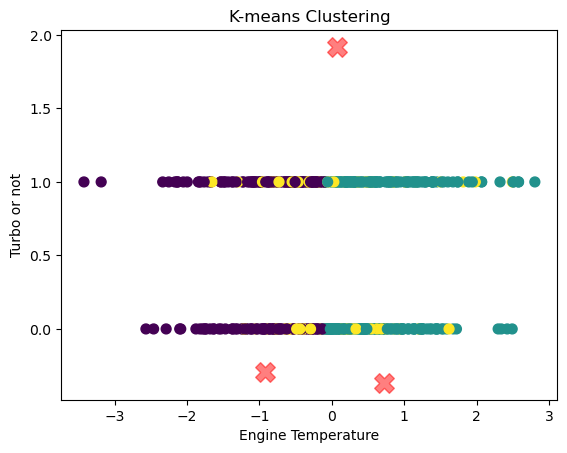

In [23]:
# Plot the clusters
plt.scatter(transformed_df['temp'], transformed_df['turbo'], c=y_kmeans, s=50, cmap='viridis')
# plt.scatter(transformed_df['cat__fuel_type_diesel'], transformed_df['num__fuel_rate'], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centers = kmeans.cluster_centers_
print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
# plt.scatter(centers[:, 3], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title('K-means Clustering')
plt.xlabel('Engine Temperature')
plt.ylabel('Turbo or not')
plt.show()


Check how difficult to interpret the clustering is over a categorical data like biofuel vs other types of fuel
It is impossible when we plot a binary against another binary because all points are in one spot and everything is in one of four points (0,0),(0,1),(1,0),(1,1)

[[ 0.72000896 -0.36723981  0.32911392  0.2742616   0.39662447  0.47257384]
 [-0.9258331  -0.27746907  0.30890052  0.37696335  0.31413613  0.58115183]
 [ 0.08599998  1.94489483  0.29166667  0.38888889  0.31944444  0.45833333]]


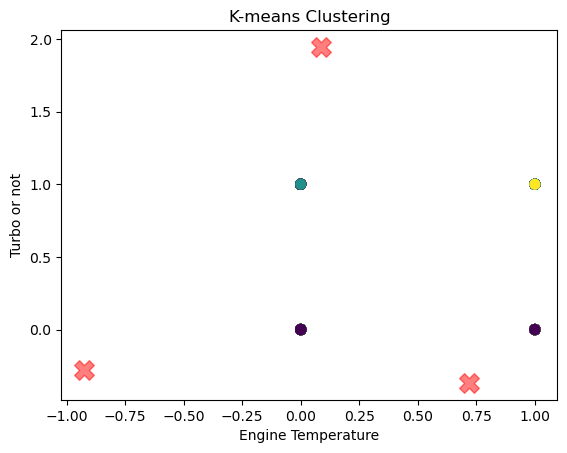

In [29]:
plt.scatter(transformed_df['biofuel'], transformed_df['turbo'], c=y_kmeans, s=50, cmap='viridis')
# plt.scatter(transformed_df['cat__fuel_type_diesel'], transformed_df['num__fuel_rate'], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centers = kmeans.cluster_centers_
print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
# plt.scatter(centers[:, 3], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title('K-means Clustering')
plt.xlabel('Engine Temperature')
plt.ylabel('Turbo or not')
plt.show()


[[-0.92809945 -0.29064339  0.31216931  0.37037037  0.31746032  0.57671958]
 [ 0.72000896 -0.36723981  0.32911392  0.2742616   0.39662447  0.47257384]
 [ 0.06444151  1.91847885  0.28378378  0.40540541  0.31081081  0.47297297]]


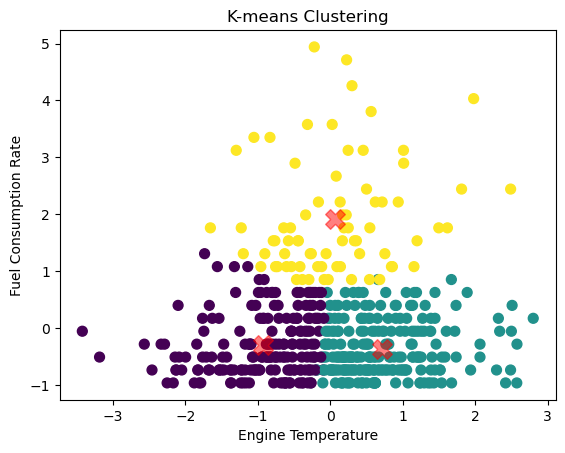

In [25]:
# Plot the clusters
plt.scatter(transformed_df['temp'], transformed_df['fuel_rate'], c=y_kmeans, s=50, cmap='viridis')
# plt.scatter(transformed_df['cat__fuel_type_diesel'], transformed_df['num__fuel_rate'], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centers = kmeans.cluster_centers_
print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
# plt.scatter(centers[:, 3], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title('K-means Clustering')
plt.xlabel('Engine Temperature')
plt.ylabel('Fuel Consumption Rate')
plt.show()


In K-means clustering, variance can refer to the within-cluster variance, which measures the compactness of the clusters formed by the K-means algorithm. The goal of K-means is to minimize this variance, effectively ensuring that objects within each cluster are as close to each other as possible, thereby maximizing the similarity within clusters.

To compute the variances for different numbers of clusters in K-means clustering, you follow these steps:

Cluster the data using K-means for different values of K: Run K-means clustering on your dataset for various values of K (where K is the number of clusters). For each K, the algorithm will assign each data point to one of the K clusters.

Calculate the within-cluster sum of squares (WCSS) for each K: For each cluster, calculate the sum of squared distances between each data point and the centroid of its assigned cluster. Then, sum these values across all clusters to obtain the total within-cluster sum of squares (WCSS). The WCSS is a measure of the total variance within the clusters.

Analyze the variance for different values of K: The WCSS can be used as a measure of variance for different numbers of clusters. As the number of clusters increases, the WCSS (or within-cluster variance) should decrease because the clusters are becoming smaller and more compact.

Here is a Python code snippet using the sklearn library to compute and plot the WCSS for different numbers of clusters in a dataset

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

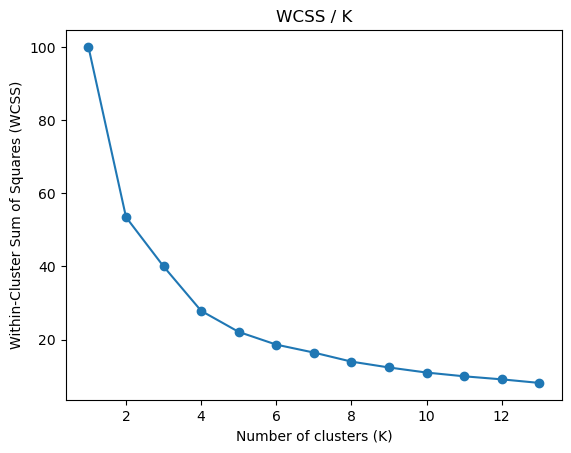

100


In [11]:
# Range of K's to try
Ks = range(1, 14)

# Calculate WCSS for each K
WCSS = []
for k in Ks:
    kmeans = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state=0)
    kmeans.fit(data)
    # to measure relative reduction in variance, we can normalzie with respect to total variance, i.e., when all points in 1 cluster or k=1
    if k==1:
        total_var = kmeans.inertia_
        WCSS.append(100)
    else:
        WCSS.append(100*kmeans.inertia_/total_var)

# Plotting the results
plt.plot(Ks, WCSS, '-o')
plt.title('WCSS / K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()
print(WCSS[0])